# Modelado en Optimización (IIND-2501)

## Lección 3.2: Optimización en problemas de estimación

In [1]:
'''
Importaciones y configuraciones generales del notebook. No modificar.
'''
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
np.set_printoptions(precision=4, suppress=True)
plt.rcParams["figure.figsize"] = (6,4)

from helpers_estimacion import ejemplo_ilustrativo, ajuste_manual, fit_ols, plot_ols

### 1 - Formular un problema de estimación

Creamos un dataset sencillo con una sola variable para poder visualizar el comportamiento de los métodos de optimización que resuelven problemas de aprendizaje (más adelante usaremos un dataset real). *Suponemos* una variable $y$ cuyo comportamiento se relaciona con otra variable $x$ de forma lineal. Por ejemplo, en determinado sector, el salario de una persona ($y$) puede depender *linealmente* de sus años de experiencia ($x$). 

$$\mathbf{y} = a + b\mathbf{x}$$

Con suficientes observaciones, podemos determinar si esto en efecto se cumple, y cuál sería la recta que nos ayuda a explicar o predecir los salarios en este sector a partir de los años de experiencia de un aspirante (i.e., qué valores de $a$ y $b$ generan buenas estimaciones de $y$ a partir de $x$).

In [2]:
datos, true_coefs = ejemplo_ilustrativo() 
datos.head()

,Años de experiencia (x),Salario normalizado (y)
0,7.5,39.0
1,19.0,87.0
2,14.6,65.1
3,12.0,55.3
4,3.1,17.2


In [3]:
n = datos.shape[0]
y = datos["Salario normalizado (y)"]
x = datos["Años de experiencia (x)"]
X = np.vstack([np.ones(n), x]).T        # extiende con columna de 1s (coeficientes del término independente a)

a_true, b_true = true_coefs

#### Ajusta $(a,b)$ manualmente para minimizar el *error*

In [4]:
ajuste_manual(x, y)

interactive(children=(FloatSlider(value=1.0, description='b (pendiente)', max=10.0, min=-10.0), FloatSlider(va…

Output()

### 2 - Cómo medir qué tan bueno es el modelo de estimación

Para valores ajustados de los coeficientes ($a'$ y $b'$), podemos hacer una estimación $\hat{y}$ a partir de un $x$ dado. Es decir que podemos evaluar, sobre la recta ajustada, *a qué salario corresponde un número dado de años de experiencia*.

$$\hat{y}=a' + b' x$$

La distancia entre el $\hat{y}$ estimado y el $y$ real de las observaciones nos da una idea de qué tan buena es la estimación lineal que logran $a'$ y $b'$. Queremos la recta que se ajusta más cercanamente a las observaciones disponibles, así que buscamos los valores de $a$ y $b$ que minimizan dicha distancia. En estadística y *machine learning*, esta distancia comúnmente se mide a través de la suma o el promedio de los **errores al cuadrado** (SSE o MSE, respectivamente). Nos proponemos encontrar el modelo (i.e., los valores de $a$ y $b$) que minimice la *suma de los errores al cuadrado*:

$$ f(a,b) = \sum_{i=1}^{N}[ y_i - \hat{y}_i ]^2 $$
$$ f(a,b) = \sum_{i=1}^{N}[ y_i - (a+b x_i)]^2 $$

Así, nuestro problema de optimización consiste en la minimizar esa función objetivo (típicamente llamada función de *error* o de *pérdida*), sin ninguna restricción en particular en este caso.

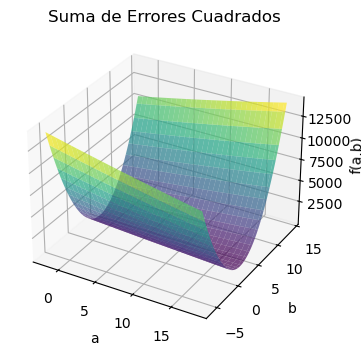

In [5]:
def sse(beta0, beta1):
    beta = np.array([beta0, beta1])
    res = y - X @ beta
    return (res @ res) / n  # multiplicar vector de residuos por si mismo da errores cuadráticos

b0 = np.linspace(a_true-10, a_true+10, 60)
b1 = np.linspace(b_true-10, b_true+10, 60)
B0, B1 = np.meshgrid(b0, b1)
J = np.vectorize(sse)(B0, B1)     # Función J recibe b0,b1, retorna MSE 

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(B0, B1, J, cmap='viridis', alpha=0.7)
ax.set_xlabel('a'); ax.set_ylabel('b'); ax.set_zlabel('f(a,b)')
plt.title('Suma de Errores Cuadrados'); plt.show()

### 3 – Solución iterativa mediante *descenso de gradiente*

Recordemos que queremos minimizar la *función de pérdida*:

$$ \min_{(a,b)} f(a,b) = \sum_{i=1}^{N}[ y_i - (a+b x_i)]^2 $$

**Importante:** en este contexto, $x$ y $y$ son "variables" de un problema estadístico, pero para nosotros son constantes porque contamos con los datos correspondientes; *las variables de nuestro problema* de optimización son $a$ y $b$, ya que buscamos los valores de éstas que más acerquen la recta a las observaciones.

Desarrollamos el elemento cuadrático para simplificar derivación:

$$f(a,b) = \sum_{i=1}^{N} \left[ y_i^2 - 2y_i a - 2 y_i x_i b + a^2 + 2 x_i a b + x_i^2 b^2 \right]$$

$$f(a,b) = \sum_{i=1}^{N} \left[ a^2 + (x_i^2) b^2 + (2 x_i) a b - (2 y_i) a - (2 y_i x_i) b + y_i^2  \right]$$

donde los $x_i$ y $y_i$ sobre los cuales estamos sumando son simplemente las observaciones del *data-set*, que funcionan como coeficientes de una función cuadrática de $a$ y $b$. Para optimizar, procedemos a encontrar las derivadas parciales de $f$ con respecto a $a$ y $b$:

$$ \frac{\partial f}{\partial a} = 2 \sum_{i=1}^{N} a + (x_i) b - y_i $$

$$ \frac{\partial f}{\partial b} = 2 \sum_{i=1}^{N} (x_i) a + (x_i^2) b - y_i x_i$$

Con estas derivadas, construimos el vector gradiente, que queda expresado como función de $a$ y $b$ (precisamente nuestro *espacio de búsqueda*):

$$
\nabla f(a,b)
=
\begin{bmatrix}
\displaystyle \frac{\partial f}{\partial a} \\[6pt]
\displaystyle \frac{\partial f}{\partial b}
\end{bmatrix}
=
2\begin{bmatrix}
\displaystyle \sum_{i=1}^N \big(a + b x_i - y_i\big) \\[8pt]
\displaystyle \sum_{i=1}^N \big(a x_i + b x_i^{2} - y_i x_i\big)
\end{bmatrix}
$$

Partiremos de un punto arbitrario $(a_0, b_0)$ y aplicaremos la ecuación de actualización de movimiento, usando siempre como dirección el **gradiente negativo**. Originalmente, la ecuación de movimiento está planteada para un $x$, así que la adaptamos a nuestro contexto con variables $a$ y $b$.

En lugar de:

$$\mathbf{x}_{t+1} = \mathbf{x}_t + \alpha \Delta \mathbf{x}$$

tendremos:

$$
\begin{bmatrix}
\displaystyle a_{t+1} \\[6pt]
\displaystyle b_{t+1}
\end{bmatrix}
=
\begin{bmatrix}
\displaystyle a_{t} \\[6pt]
\displaystyle b_{t}
\end{bmatrix}
- 2 \alpha 
\begin{bmatrix}
\displaystyle \sum_{i=1}^N \big(a_t + b_t x_i - y_i\big) \\[8pt]
\displaystyle \sum_{i=1}^N \big(a_t x_i + b_t x_i^{2} - y_i x_i\big)
\end{bmatrix}
$$

Con esa ecuación, iremos mejorando los valores de $a$ y $b$, empezando en $a_0$ y $b_0$, con actualizaciones que solo dependen del punto actual y de los valores de las observaciones (los $x_i$ y $y_i$).

In [6]:
'''
Por practicidad y eficiencia, el código se implementa de forma vectorial y con notación estadística.
    beta = [beta_0, beta_1] = [a, b]
    (X, y): variables de la regresión lineal
    res: residuo (error)

Queda como ejercicio opcional revisarlo, y contrastar con versión explícita
'''

def gradient_descent(X, y, alpha=0.001, max_iter=5000, tol=1e-6):
    n, p = X.shape
    beta = np.ones(p)           # iniciamos suponiendo [a,b]=[b0,b1]=[1,1] e iteramos
    traj_beta = [beta.copy()]   # acumula histórico variables
    traj_J = []                 # acumula histórico objetivo
    for it in range(max_iter):
        res = y - X @ beta
        grad = -(2/n) * X.T @ res
        beta_new = beta - alpha * grad
        traj_beta.append(beta_new.copy())
        traj_J.append((res @ res)/n)
        if np.linalg.norm(beta_new - beta) < tol:
            break
        beta = beta_new
    return beta, np.array(traj_beta), traj_J

beta_gd, traj_b, traj_J = gradient_descent(X, y)
print('Coeficientes según gradiente:', beta_gd)

Coeficientes según gradiente: [7.0456 4.091 ]


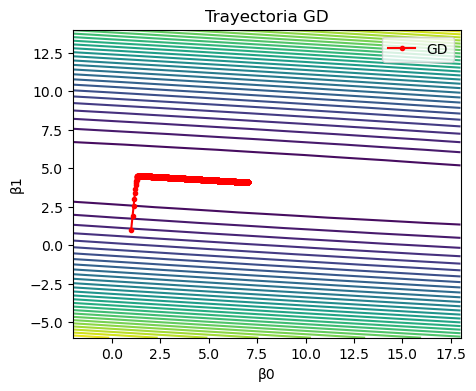

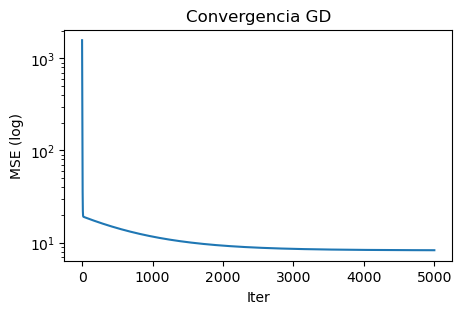

In [7]:
plt.figure(figsize=(5,4))
plt.contour(B0, B1, J, levels=30, cmap='viridis')
plt.plot(traj_b[:,0], traj_b[:,1], 'r.-', label='GD')
#plt.scatter(beta_closed[0], beta_closed[1], c='black', label='closed‑form')
plt.xlabel('β0'); plt.ylabel('β1'); plt.title('Trayectoria GD'); plt.legend(); plt.show()

plt.figure(figsize=(5,3))
plt.plot(traj_J); plt.yscale('log')
plt.xlabel('Iter'); plt.ylabel('MSE (log)'); plt.title('Convergencia GD'); plt.show()

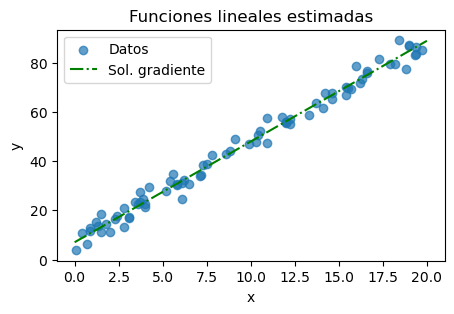

In [8]:
def plot_regression(x, y, beta_gd):
    plt.figure(figsize=(5,3))
    plt.scatter(x, y, alpha=0.7, label='Datos')
    xs = np.linspace(0, 20, 100)    
    plt.plot(xs, beta_gd[0] + beta_gd[1]*xs, '-.', color='g', label='Sol. gradiente')
    plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.title('Funciones lineales estimadas')
    plt.show()

plot_regression(x, y, beta_gd)

### 4 - Ejemplo con datos reales (regresión lineal)

#### Estimar costo de viviendas a partir del ingreso mediano

Usaremos el caso *California Housing* disponible en la librería scikit-learn de Python. La intuición general es que barrios con **mayor ingreso mediano** tienden a tener **viviendas más costosas**.

Usaremos dos de las variables del *dataset*:
- $x$: ingreso mediano del bloque (en decenas de miles USD)
- $y$: valor mediano de vivienda (en centenas de miles USD)

Se busca un modelo lineal del tipo:

$$ y = a + b x $$

In [9]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)
df = data.frame.rename(columns=str)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [10]:
# Variables: x = ingreso mediano del bloque (en decenas de miles USD), y = valor mediano de vivienda (en centenas de miles USD)
x = df["MedInc"].values
y = df["MedHouseVal"].values

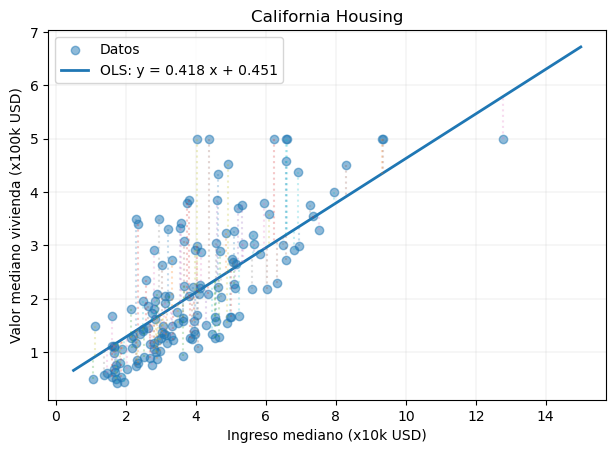

In [11]:
# Visualización con residuos (solucionada internamente con el paquete numpy)
plot_ols(
    x, y,
    title="California Housing",
    xlabel="Ingreso mediano (x10k USD)",
    ylabel="Valor mediano vivienda (x100k USD)",
)

#### Ejercicio:

Encontrar los parámetros que minimizan el MSE para el ejemplo de **California Housing** utilizando el algoritmo de descenso de gradiente.

In [12]:
# Desarrolla aquí tu solución



De manera general, se le llama $\theta$ o $\beta$ al vector que agrupa los coeficientes de la relación lineal entre $x$ y $y$ (es decir, los coeficiente $a$ y $b$, y otros cuando se incluyen más variables). Así, con $\mathbf{\beta}=[\beta_0, \beta_1]$, tendríamos:

$$y = \beta_0 + \beta_1 x$$

Y de manera general, $y = \mathbf{\beta}X$. Una manera formal de escribir algebraicamente el MSE es a través de la norma del vector diferencia entre el $y$ real y el $y$ estimado ($\mathbf{\beta}X$):

$$J(\beta) = \|y - X\beta\|_2^2$$

Por tratarse de una función cuadrática (convexa), sabemos que el mínimo estará en el punto donde "la derivada" se hace cero, lo cual se extiende al concepto de gradiente y se conoce como *condiciones de primer orden* (el óptimo deberá cumplir $\nabla J = 0$):

$$ -2X^\top(y - X\beta)=0$$
$$ (X^\top X)\beta = X^\top y$$
$$\hat\beta=(X^\top X)^{-1}X^\top y$$